# Rainfall Weather Forecasting

In [1]:
#Importing necessary libraries

In [10]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,roc_auc_score,cohen_kappa_score,f1_score,confusion_matrix,classification_report,roc_curve

import time
import pickle
from collections import Counter

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import LogisticRegression



import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/dsrscientist/dataset3/main/weatherAUS.csv')
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
8421,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
8422,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
8423,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [11]:
df.isnull().sum()

Date                0
Location            0
MinTemp            75
MaxTemp            60
Rainfall          240
Evaporation      3512
Sunshine         3994
WindGustDir       991
WindGustSpeed     991
WindDir9am        829
WindDir3pm        308
WindSpeed9am       76
WindSpeed3pm      107
Humidity9am        59
Humidity3pm       102
Pressure9am      1309
Pressure3pm      1312
Cloud9am         2421
Cloud3pm         2455
Temp9am            56
Temp3pm            96
RainToday         240
RainTomorrow      239
dtype: int64

In [12]:
#so many nulls are present in the data

In [13]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_features = [feature for feature in numerical_features if len(df[feature].unique())<25]
continuous_features = [feature for feature in numerical_features if feature not in discrete_features]
categorical_features = [feature for feature in df.columns if feature not in numerical_features]
binary_categorical_features = [feature for feature in categorical_features if len(df[feature].unique()) <=3]
print("Numerical Features Count {}".format(len(numerical_features)))
print("Discrete features Count {}".format(len(discrete_features)))
print("Continuous features Count {}".format(len(continuous_features)))
print("Categorical features Count {}".format(len(categorical_features)))
print("Binary Categorical features Count {}".format(len(binary_categorical_features)))

Numerical Features Count 16
Discrete features Count 2
Continuous features Count 14
Categorical features Count 7
Binary Categorical features Count 2


In [14]:
def generate_distribution_plot(df, continuous_features):
    # create copy of dataframe
    data = df[continuous_features].copy()
    # Create subplots 
    fig, axes = plt.subplots(nrows=len(data.columns)//2, ncols=2,figsize=(15,20))
    fig.subplots_adjust(hspace=0.7)
    
    # set fontdict
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    
    # Generate distplot
    for ax, feature in zip(axes.flatten(), data.columns):
        sns.distplot(data[feature],ax=ax)
        ax.set_title(f'Analysis of {feature}', fontdict=font)
    plt.show()

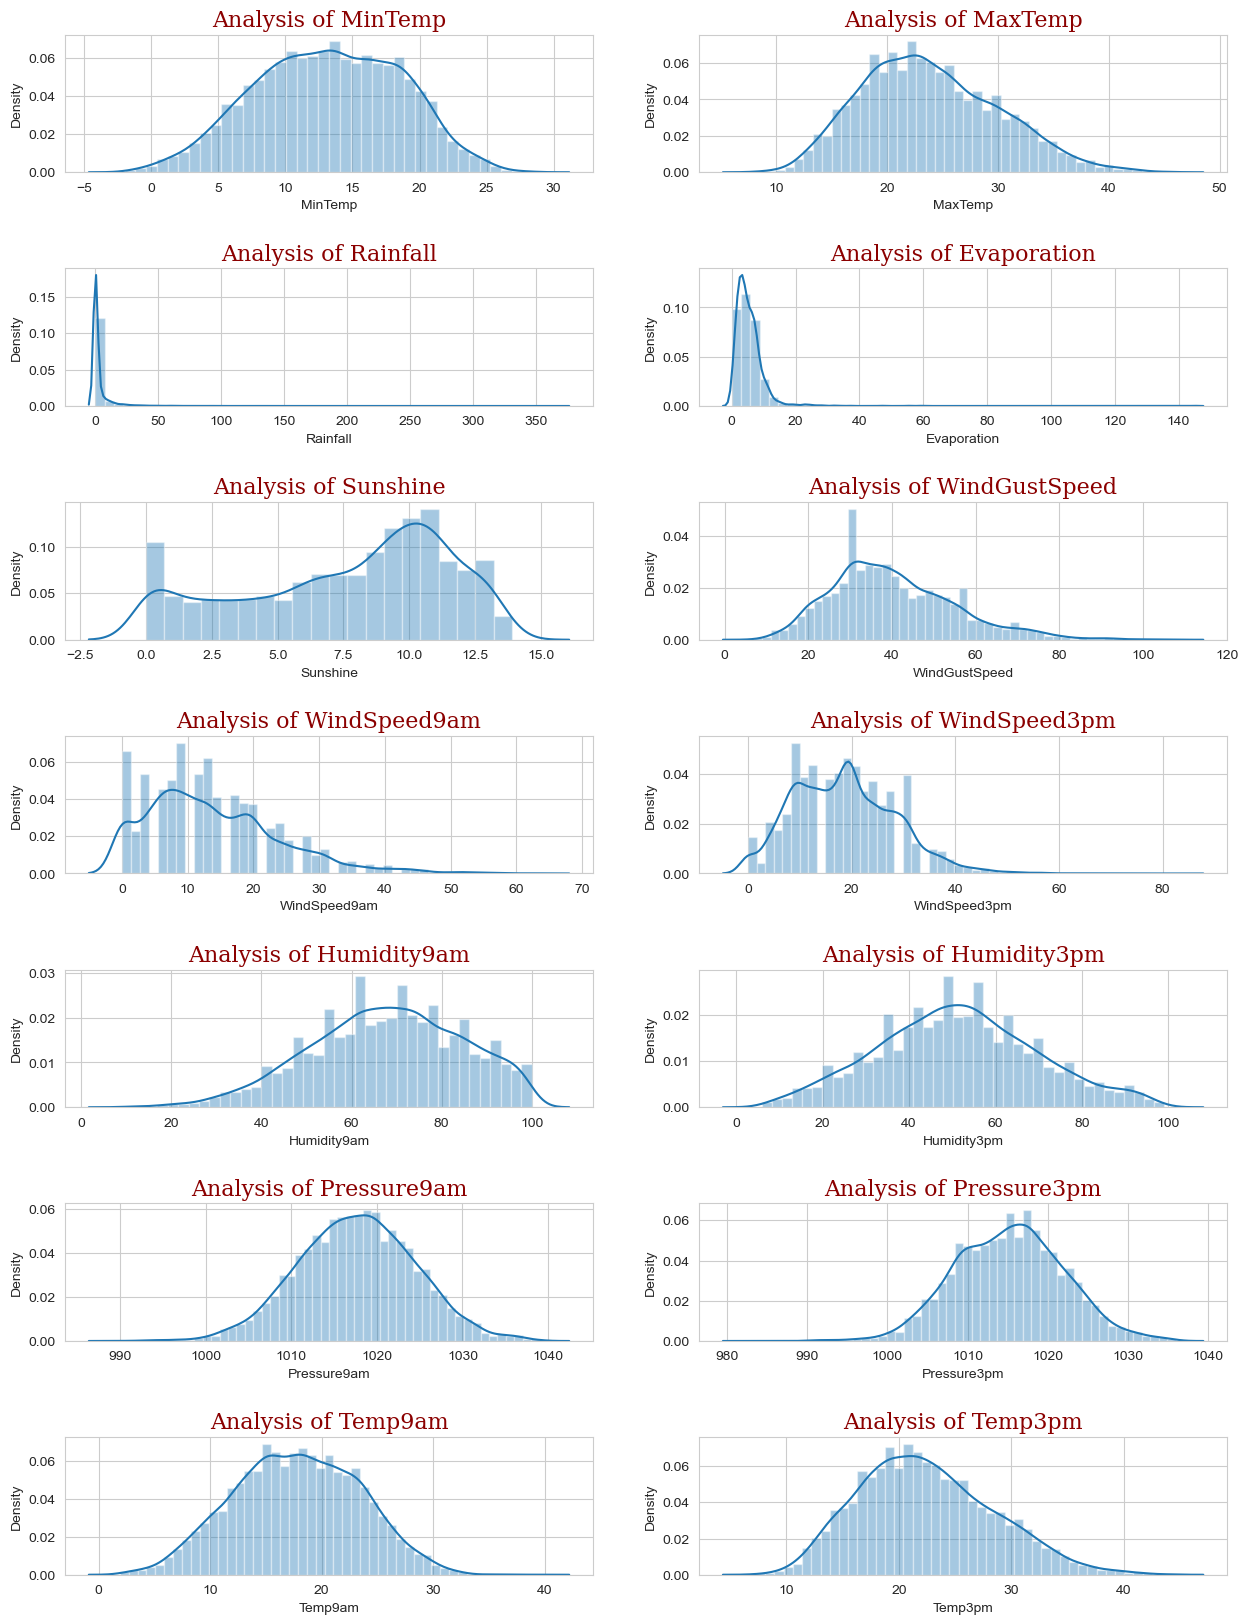

In [15]:
generate_distribution_plot(df, continuous_features)

In [16]:
sample_imputation_features = [col for col in df.columns if (df.isnull().sum()[col] > 50000)]

In [17]:
def randomsampleimputation(df, columns):
    data = df.copy()
    for column in columns:
        random_sample = data[column].dropna().sample(data[column].isnull().sum(),random_state=2022)
        random_sample.index = data[data[column].isnull()].index
        data.loc[data[column].isnull(),column] = random_sample
    return data

In [18]:
df = randomsampleimputation(df,sample_imputation_features)

In [19]:
missing_values_numeric_features  = [col for col in df.columns if (df.isnull().sum()[col] > 0) & (df[col].dtypes != 'object')]

In [20]:
# Filling the Missing Values – Imputation
# Filling the missing data with the mean value for a numerical variable


# function for missing values substitution
def impute_means(df, missing_values_columns):
    data = df.copy()
    '''Filling missing values with mean'''
    for col in missing_values_columns:
        data[col] = data[col].fillna(data[col].mean())
        
    return data

In [21]:
df = impute_means(df,missing_values_numeric_features)

In [22]:
df.isnull().sum()

Date               0
Location           0
MinTemp            0
MaxTemp            0
Rainfall           0
Evaporation        0
Sunshine           0
WindGustDir      991
WindGustSpeed      0
WindDir9am       829
WindDir3pm       308
WindSpeed9am       0
WindSpeed3pm       0
Humidity9am        0
Humidity3pm        0
Pressure9am        0
Pressure3pm        0
Cloud9am           0
Cloud3pm           0
Temp9am            0
Temp3pm            0
RainToday        240
RainTomorrow     239
dtype: int64

In [23]:
def plot_boxplot(df, continuous_features):
    # create copy of dataframe
    data = df[continuous_features].copy()
    # Create subplots 
    fig, axes = plt.subplots(nrows=len(data.columns)//2, ncols=2,figsize=(15,20))
    fig.subplots_adjust(hspace=0.7)
    
    # set fontdict
    font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 16,
        }
    
    # Generate distplot
    for ax, feature in zip(axes.flatten(), data.columns):
        sns.boxplot(data[feature],ax=ax)
        ax.set_title(f'Analysis of {feature}', fontdict=font)
    plt.show()

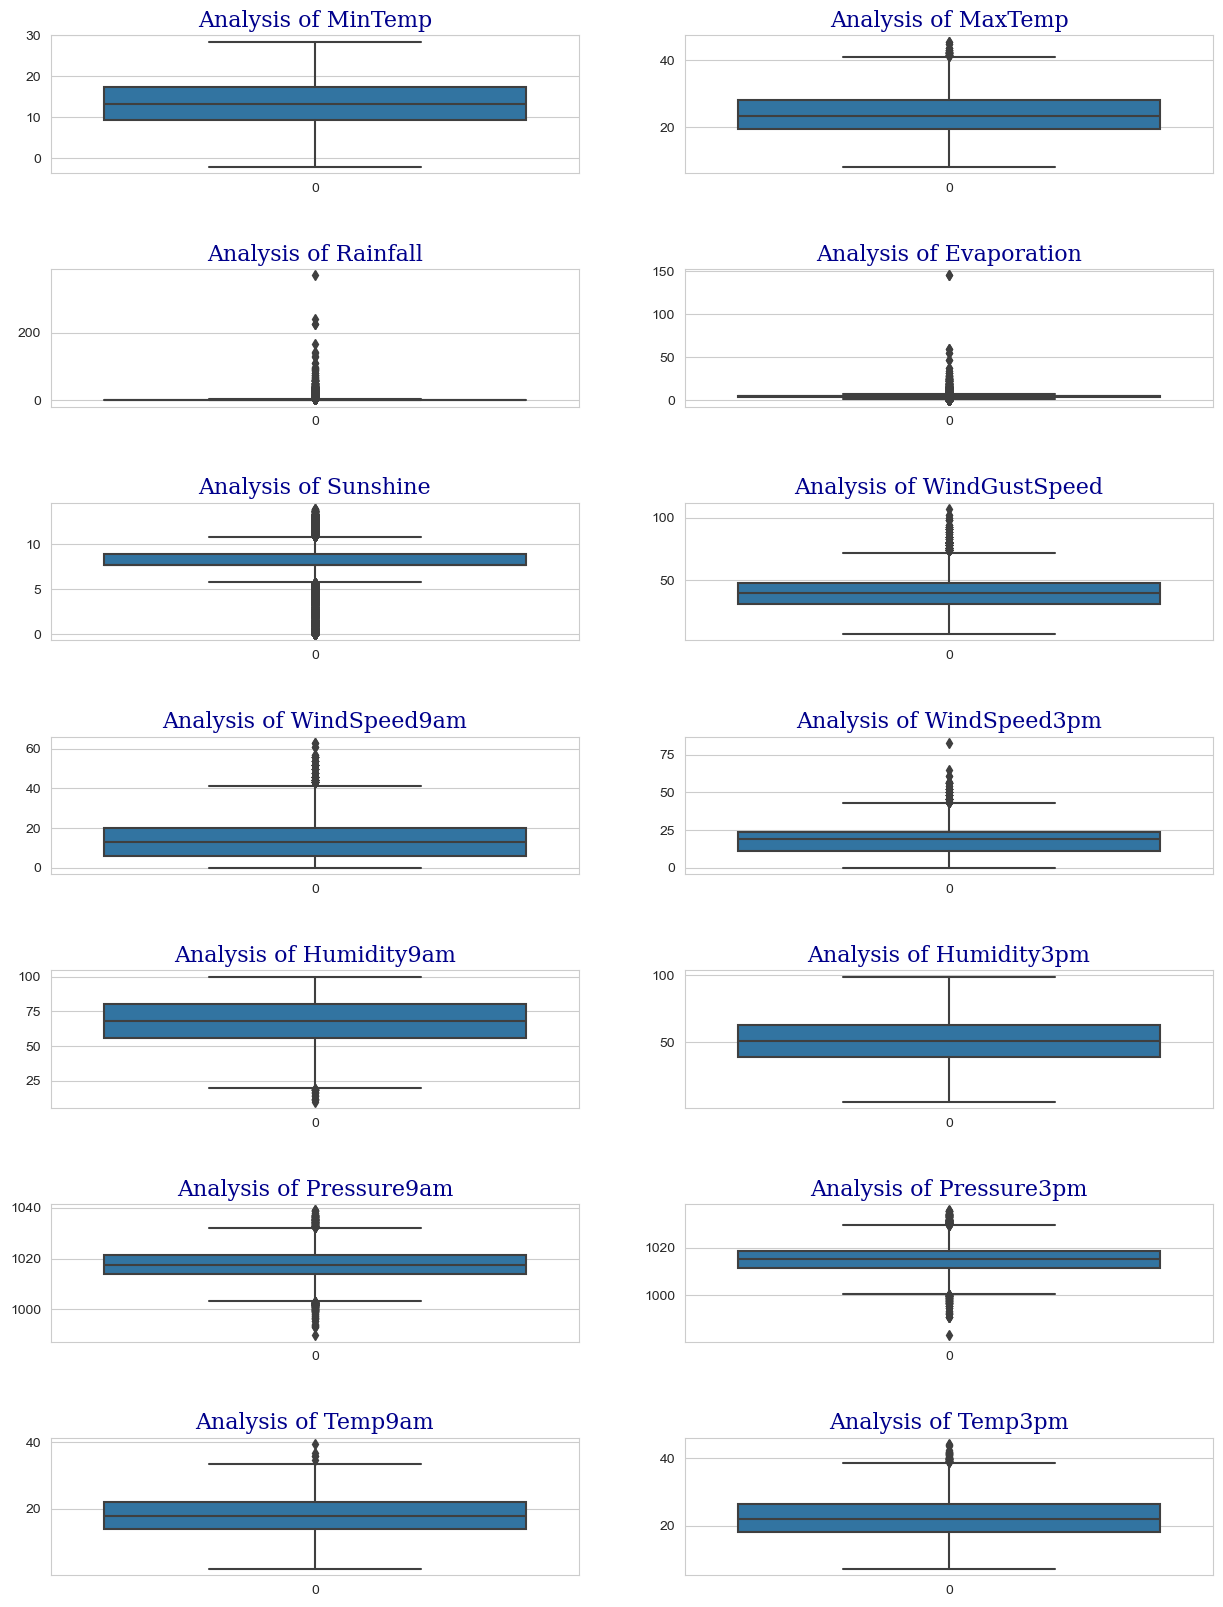

In [24]:
plot_boxplot(df, continuous_features)

In [25]:
outliers_features = [feature for feature in continuous_features if feature not in ['Sunshine','Humidity3pm']]
print(outliers_features)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']


In [26]:
def remove_outliers(df,outliers_features):
    # create copy of dataframe
    
    data = df.copy()
    
    for feature in data[outliers_features].columns:
        Q3 = data[feature].quantile(0.75)
        Q1 = data[feature].quantile(0.25)
        IQR = Q3 - Q1
        lower_limit = round(Q1 - 1.5 * IQR)
        upper_limit = round(Q3 + 1.5 * IQR)
        data.loc[data[feature]>= upper_limit,feature] = upper_limit
        data.loc[data[feature]<=lower_limit,feature] = lower_limit
#         data = data[(data[feature] < upper_limit) & (data[feature] > lower_limit)]
    return data

In [27]:
df = remove_outliers(df,outliers_features)

In [28]:
df.shape

(8425, 23)

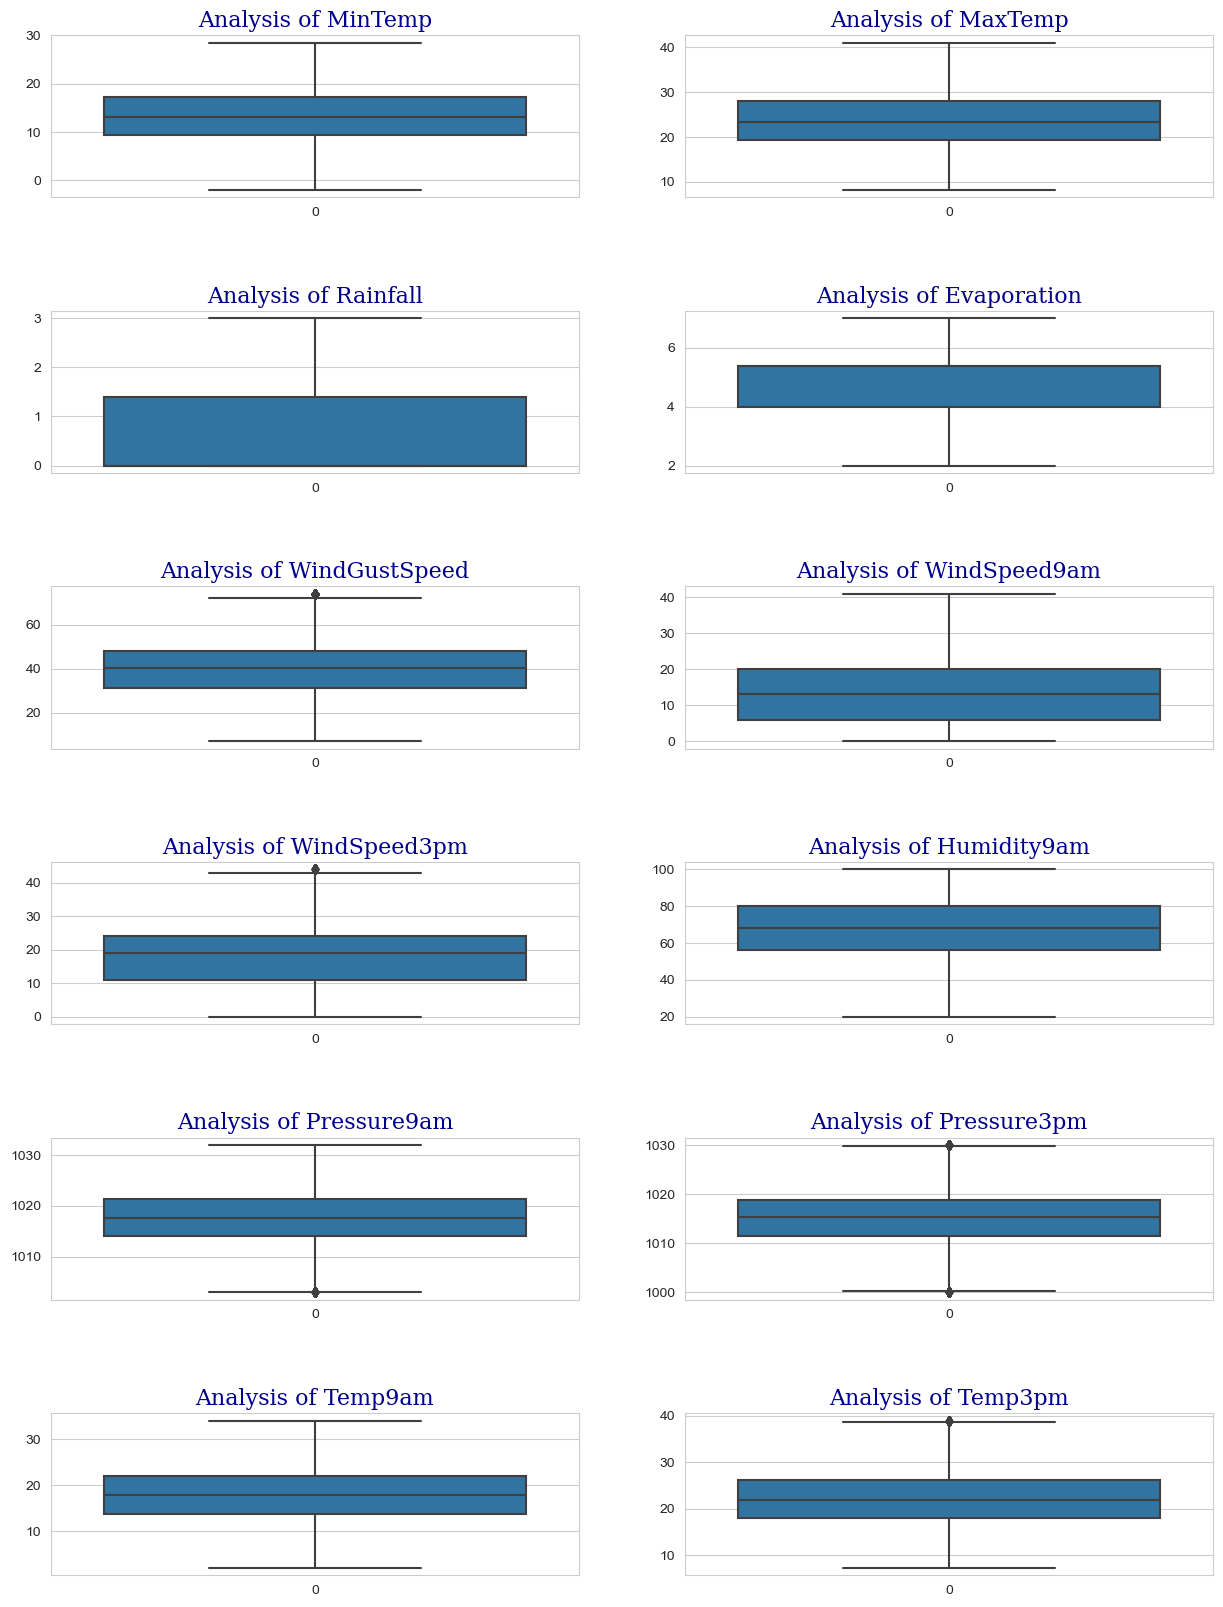

In [29]:
plot_boxplot(df, outliers_features)

In [30]:
df['RainToday'] = df['RainToday'].fillna('No')
# Raintomorrow
df['RainTomorrow'] = df['RainTomorrow'].fillna('No')

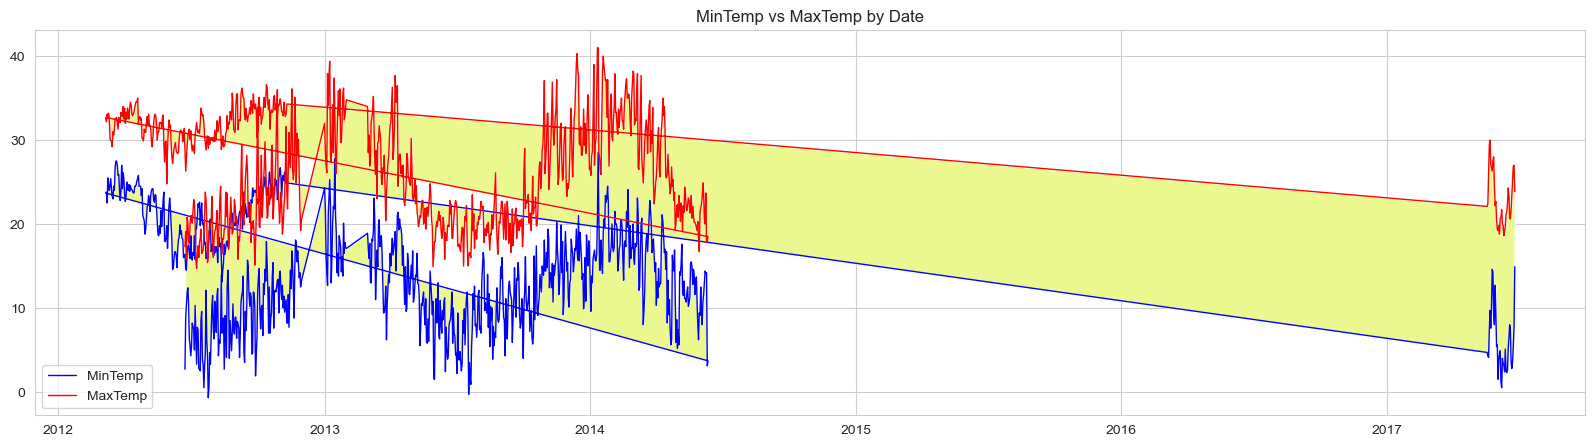

In [33]:
df["Date"] = pd.to_datetime(df["Date"])
# using data from last 3 years.
df_last_3_years = df.iloc[-950:,:]
plt.figure(figsize=[20,5])
plt.plot(df_last_3_years['Date'],df_last_3_years['MinTemp'],color='blue',linewidth=1, label= 'MinTemp')
plt.plot(df_last_3_years['Date'],df_last_3_years['MaxTemp'],color='red',linewidth=1, label= 'MaxTemp')
plt.fill_between(df_last_3_years['Date'],df_last_3_years['MinTemp'],df_last_3_years['MaxTemp'], facecolor = '#EBF78F')
plt.title('MinTemp vs MaxTemp by Date')
plt.legend(loc='lower left')
plt.show()

In [34]:
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["day"] = df["Date"].dt.day

# We don't need date feature anymore for model building
df.drop('Date', axis=1, inplace=True)

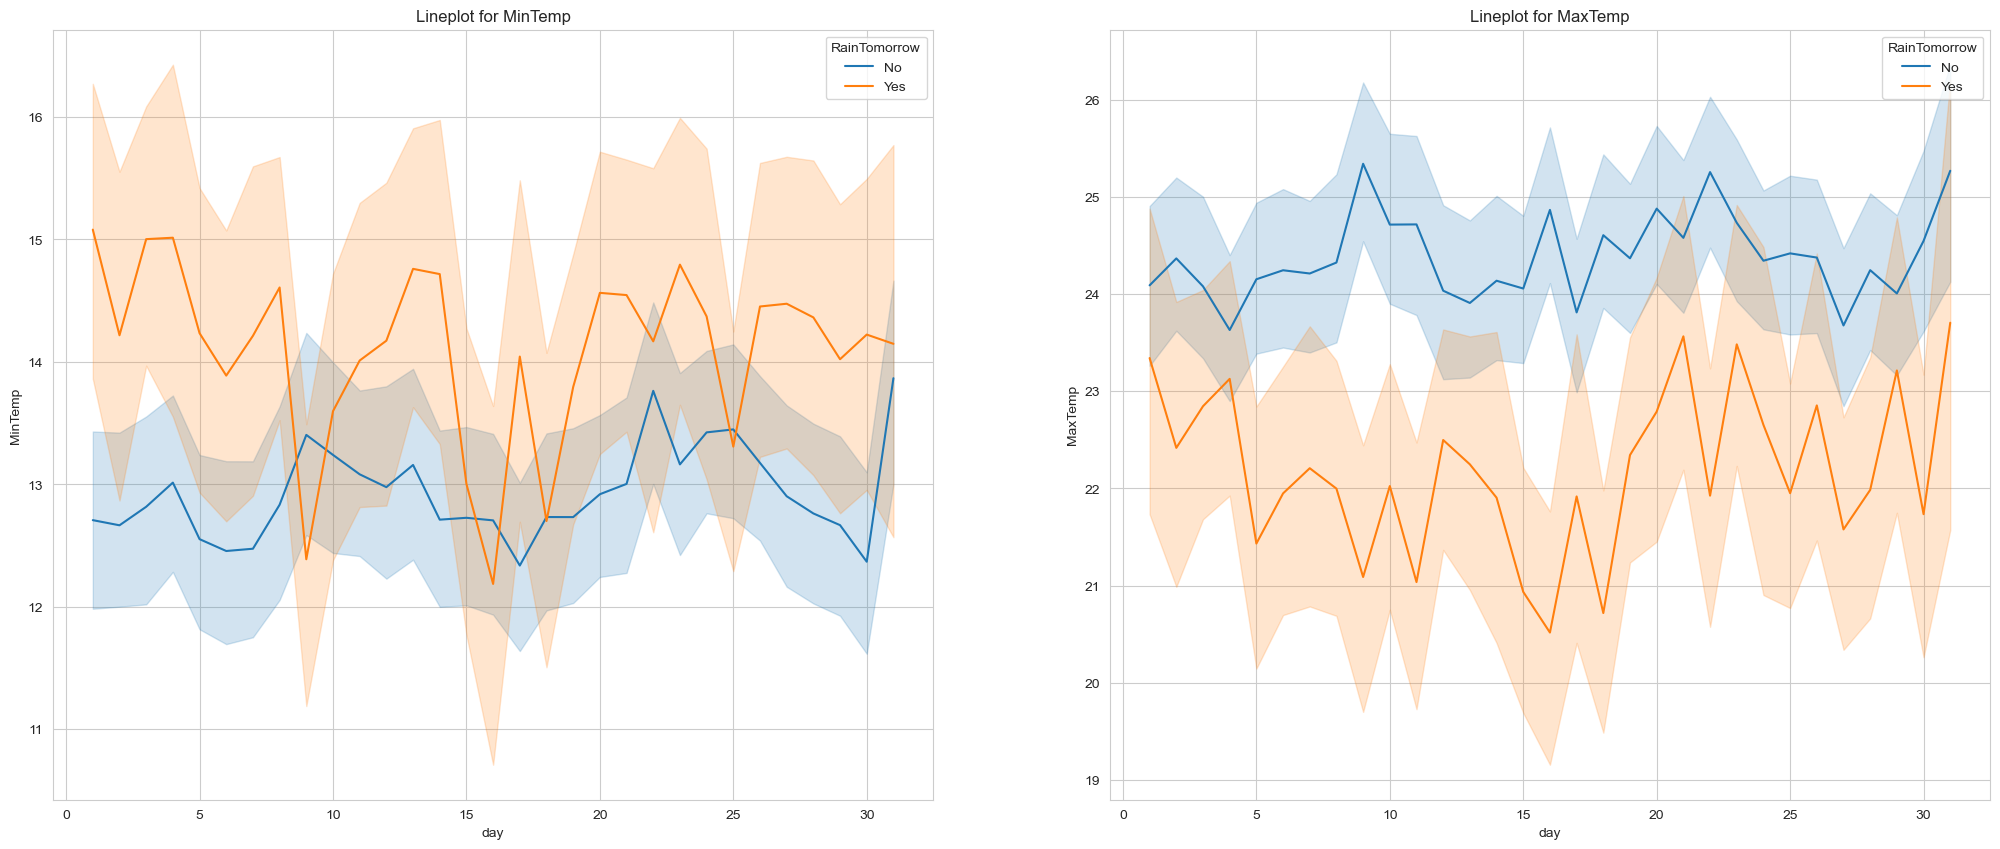

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Mintemp
sns.lineplot(ax=axes[0],x="day",y="MinTemp",hue="RainTomorrow",data=df)
axes[0].set_title('Lineplot for MinTemp')
# Maxtemp
sns.lineplot(ax=axes[1],x="day",y="MaxTemp",hue="RainTomorrow",data=df)
axes[1].set_title('Lineplot for MaxTemp')
plt.show()

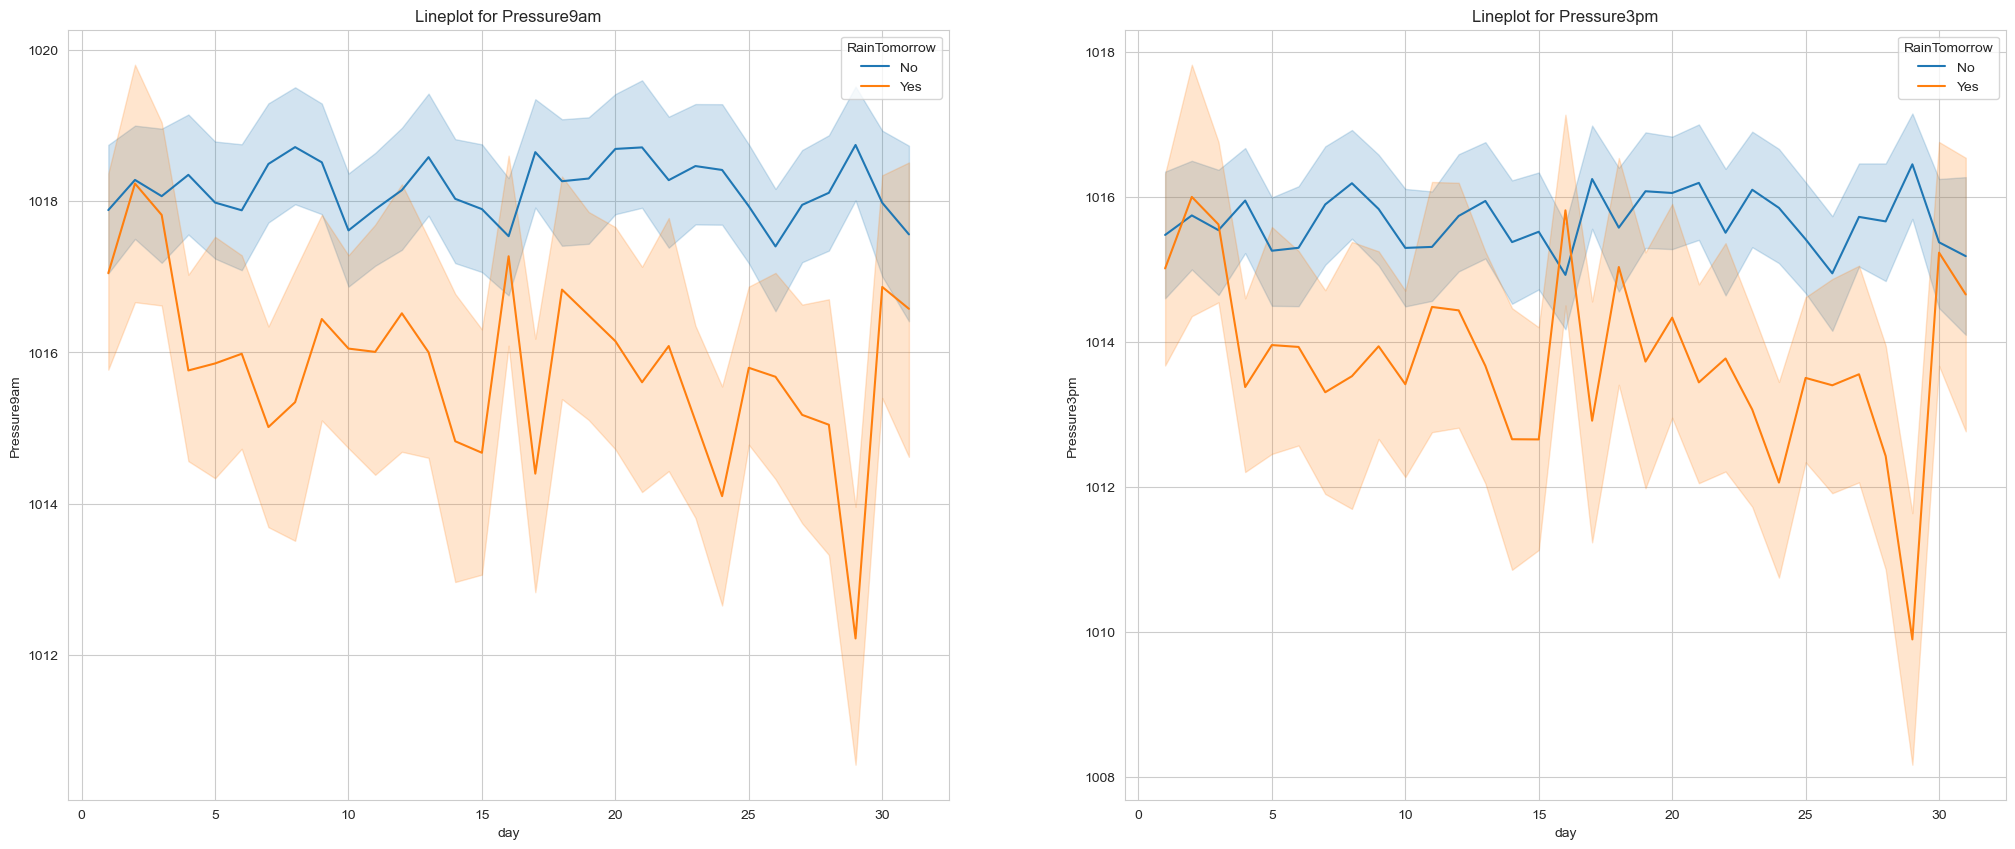

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

# Pressure9am
sns.lineplot(ax=axes[0],x="day",y="Pressure9am",hue="RainTomorrow",data=df)
axes[0].set_title('Lineplot for Pressure9am')
# Pressure3pm
sns.lineplot(ax=axes[1],x="day",y="Pressure3pm",hue="RainTomorrow",data=df)
axes[1].set_title('Lineplot for Pressure3pm')
plt.show()

In [38]:
# For binary features, we'll use labelencoding
le = LabelEncoder()

label_encoder_features = binary_categorical_features

for col in label_encoder_features:
    df[col] = le.fit_transform(df[col])

In [39]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day
0,Albury,13.4,22.9,0.6,5.389395,7.632205,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503183,16.9,21.8,0,0,2008,12,1
1,Albury,7.4,25.1,0.0,5.389395,7.632205,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.566622,4.503183,17.2,24.3,0,0,2008,12,2
2,Albury,12.9,25.7,0.0,5.389395,7.632205,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.566622,2.000000,21.0,23.2,0,0,2008,12,3
3,Albury,9.2,28.0,0.0,5.389395,7.632205,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.566622,4.503183,18.1,26.5,0,0,2008,12,4
4,Albury,17.5,32.3,1.0,5.389395,7.632205,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0,0,2008,12,5


In [40]:
# creating list of categorical columns for one hot encoding
categorical_columns = [col for col in df.columns if df.dtypes[col] == 'object']
print('Categorical Features are : ',categorical_columns)

Categorical Features are :  ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [41]:
def onehot_encoder(df, cols):
    data = df.copy()
    for col in cols:
        dummies = pd.get_dummies(data[col],drop_first=True,prefix=col)
        # concatenating dummies and original dataframe
        data = pd.concat([data, dummies], axis=1)
        
        # dropping original columns for which encoding is applied.
        data.drop(col, axis=1,inplace=True)
    return data

In [42]:
df = onehot_encoder(df,categorical_columns)

In [43]:
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,year,month,day,Location_Albury,Location_Brisbane,Location_CoffsHarbour,Location_Darwin,Location_Melbourne,Location_Newcastle,Location_Penrith,Location_PerthAirport,Location_Uluru,Location_Williamtown,Location_Wollongong,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,13.4,22.9,0.6,5.389395,7.632205,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503183,16.9,21.8,0,0,2008,12,1,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,7.4,25.1,0.0,5.389395,7.632205,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,4.566622,4.503183,17.2,24.3,0,0,2008,12,2,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,12.9,25.7,0.0,5.389395,7.632205,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,4.566622,2.000000,21.0,23.2,0,0,2008,12,3,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,9.2,28.0,0.0,5.389395,7.632205,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,4.566622,4.503183,18.1,26.5,0,0,2008,12,4,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,17.5,32.3,1.0,5.389395,7.632205,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0,0,2008,12,5,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [44]:
#MODEL BUILDING

In [45]:
# splitting the data into X and y
X = df.drop('RainTomorrow', axis=1)
y = df['RainTomorrow']

In [46]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [47]:
# Scaling Numerical Features - Imbalanced data

scaler = RobustScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [48]:
# oversampling using SMOTE
sm = SMOTE(random_state=2022)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_sm)))

The number of classes before fit Counter({0: 5147, 1: 1593})
The number of classes after fit Counter({0: 5147, 1: 5147})


In [50]:
def NeuralNetwork(num_features=X.shape[1], hidden_layer_sizes=(16, 8)):
    # Adding Input layer
    inputs = Input(shape=(num_features,))
    # Adding dense layer
    x = Dense(hidden_layer_sizes[0], activation='relu')(inputs)
    # Adding dense layer again
    x = Dense(hidden_layer_sizes[1], activation='relu')(x)
    # Adding output layer
    outputs = Dense(2, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [72]:
# Models
models = [ LogisticRegression(solver='liblinear',penalty='l1'),
           RandomForestClassifier(max_depth=16,min_samples_leaf= 1,min_samples_split= 2,n_estimators= 200,random_state=2022)]
        

model_names=['Logistic Regression','Random Forest']

In [73]:
def build_models(models, model_names):
    # lets create an empty lists to append the results
    roc_auc_scores  = []
    cohens_kappa_scores = []
    time_taken_by_model = []
    results = {}
    
    # use enumerate() and zip() function to iterate the lists
    for idx, (ml_model_names, ml_models) in enumerate(zip(model_names, models)):
        if ml_model_names == 'Neural Network':
            t0 = time.time()
            nn_model = models[idx]
            history = nn_model.fit(X_train_sm,
                                y_train_sm,
                                validation_split=0.2,
                                epochs=10,
                                batch_size=32,
                                verbose=0
                                )
            predictions_nn = nn_model.predict(X_test)
            y_pred_nn = list(map(lambda x: np.argmax(x), predictions_nn))
            roc_auc_scores.append(roc_auc_score(y_test, y_pred_nn))
            cohens_kappa_scores.append(cohen_kappa_score(y_test, y_pred_nn))
            time_taken = time.time()-t0
            time_taken_by_model.append(time_taken)
        else:
            t0 = time.time()
            clf = models[idx]
            clf.fit(X_train_sm,y_train_sm)
            y_pred = clf.predict(X_test)
            roc_auc_scores.append(roc_auc_score(y_test, y_pred, average=None))
            cohens_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
            time_taken = time.time()-t0
            time_taken_by_model.append(time_taken)
            
    results = {'Model':model_names,
           'ROC_AUC_Score':roc_auc_scores,
           'Cohen_Kappa':cohens_kappa_scores,
           'Time Taken':time_taken_by_model}
    
    # Put the roc_auc_scores and cohens kappa scores in a data frame.
    models_scores_df = pd.DataFrame(results)
    return models_scores_df

In [74]:
models_scores_df = build_models(models, model_names)

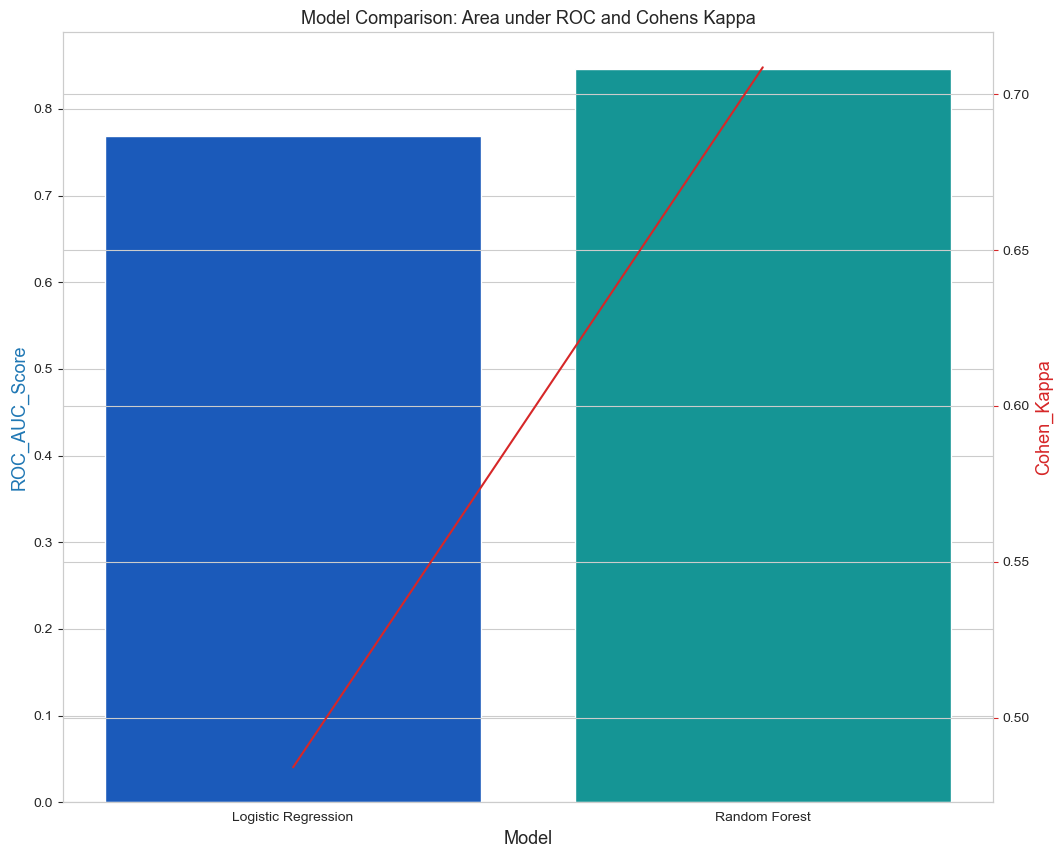

In [75]:
fig, ax1 = plt.subplots(figsize=(12,10))
ax1.set_title('Model Comparison: Area under ROC and Cohens Kappa', fontsize=13)
color = 'tab:blue'
ax1.set_xlabel('Model', fontsize=13)
ax1.set_ylabel('ROC_AUC', fontsize=13, color=color)
ax2 = sns.barplot(x='Model', y='ROC_AUC_Score', data = models_scores_df, palette='winter')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Cohen_Kappa', fontsize=13, color=color)
ax3 = sns.lineplot(x='Model', y='Cohen_Kappa', data = models_scores_df, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

In [85]:
!pip3 install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/e8/37/3afd3c02798734efcd7840bfa872d3efc06f5d5c92f9613fea3ff5b4311f/catboost-1.2.3-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 495.5 kB/s eta 0:03:24
   ---------------------------------------- 0.2/101.1 MB 2.3 MB/s eta 0:00:45
   ---------------------------------------- 0.5/101.1 MB 3.1 MB/s eta 0:00:33
   ---------------------------------------- 0.7/101.1 MB 3.5 MB/s eta 0:00:29
   ---------------------------------------- 1.0/101.1 MB 4.4 MB/s eta 0:00:23
    --------------------------------------- 1.4/101.1 

In [86]:
from catboost import CatBoostClassifier

In [87]:
cat_sm = CatBoostClassifier(iterations=2000, eval_metric = "AUC",verbose=0)
cat_sm.fit(X_train_sm, y_train_sm,verbose=0)

In [88]:
y_pred_cat = cat_sm.predict(X_test)
print(confusion_matrix(y_test,y_pred_cat))
print(accuracy_score(y_test,y_pred_cat))
print(classification_report(y_test,y_pred_cat))

[[1223   64]
 [ 123  275]]
0.8890207715133531
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1287
           1       0.81      0.69      0.75       398

    accuracy                           0.89      1685
   macro avg       0.86      0.82      0.84      1685
weighted avg       0.89      0.89      0.89      1685



In [90]:
def make_confusion_matrix(y_test,y_pred):
    cm = confusion_matrix(y_test,y_pred)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    categories = ['No','Yes']


    sns.heatmap(cm, annot=labels, fmt='',xticklabels=categories,yticklabels=categories)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

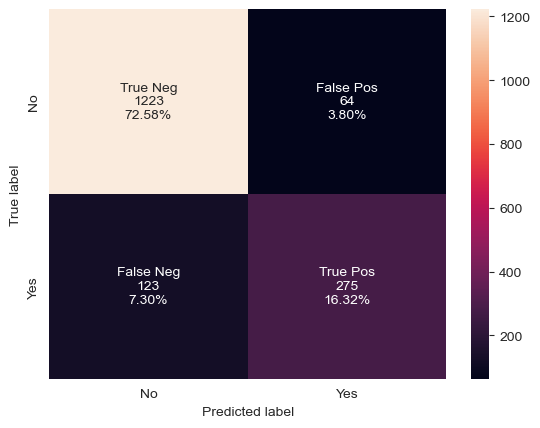

In [91]:
make_confusion_matrix(y_test, y_pred_cat)

In [95]:
# saving model
def save_model(model, directory_name, file_name):
    '''Check if directory exists, if not, create it'''
    CHECK_FOLDER = os.path.isdir(directory_name)

    # If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(directory_name)
        print("created folder : ", directory_name)
        filepath = os.path.join(directory_name, file_name)
        # save the model to disk
        pickle.dump(model, open(filepath, 'wb'))
        print("File Saved Successfully")

    else:
        print(directory_name, "folder already exists.")
        filepath = os.path.join(directory_name, file_name)
        # save the model to disk
        pickle.dump(model, open(filepath, 'wb'))
        print("File Saved Successfully")

# Apply function save_model to save the model